<a href="https://colab.research.google.com/github/muksmuks/computer_vision/blob/master/project_18/W18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
input_folder = 'gdrive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_19/input/'
output_dir = 'gdrive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_19/output/'
#output_dir_hyundai = 'gdrive/My Drive/Learnings/Machine Learning/Deep Learning/EVA/Week_19/temp/hyundai'

#input_temp_dir = os.path.join(output_dir_maruti, output_dir_hyundai)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# load all images in a directory
from os import listdir
from matplotlib import image
import cv2
# load all images in a directory
loaded_images = list()
for filename in listdir(input_folder):
	# load image
	img_data = image.imread(input_folder + filename)
	# store loaded image
	loaded_images.append(cv2.resize(img_data,(64,64)))
	#print('> loaded %s %s' % (filename, img_data.shape))
 

In [0]:
import numpy as np 
loaded_images_np = np.array(loaded_images)

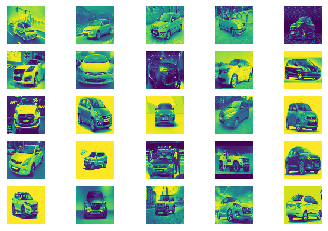

In [0]:
import matplotlib.pyplot as plt

r, c = 5, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(loaded_images_np[cnt, :,:,0])
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam



import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 64*64*3

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(12288))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()

        X_train = loaded_images_np

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            print(type(imgs[0]))

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(output_dir+"/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=200)

Using TensorFlow backend.





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               6291968   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 6,423,553
Trainable params: 6,423,553
Non-trainable params: 0
_________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



0 [D loss: 0.653065, acc.: 42.19%] [G loss: 0.433434]
<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.544845, acc.: 76.56%] [G loss: 0.594823]
<class 'numpy.ndarray'>
2 [D loss: 0.960425, acc.: 67.19%] [G loss: 1.224353]
<class 'numpy.ndarray'>
3 [D loss: 1.600717, acc.: 65.62%] [G loss: 1.970824]
<class 'numpy.ndarray'>
4 [D loss: 1.556323, acc.: 73.44%] [G loss: 2.282626]
<class 'numpy.ndarray'>
5 [D loss: 1.080482, acc.: 79.69%] [G loss: 3.131558]
<class 'numpy.ndarray'>
6 [D loss: 0.991515, acc.: 84.38%] [G loss: 3.956631]
<class 'numpy.ndarray'>
7 [D loss: 1.135281, acc.: 75.00%] [G loss: 4.017923]
<class 'numpy.ndarray'>
8 [D loss: 1.220132, acc.: 73.44%] [G loss: 5.015587]
<class 'numpy.ndarray'>
9 [D loss: 0.934491, acc.: 79.69%] [G loss: 5.549741]
<class 'numpy.ndarray'>
10 [D loss: 0.491515, acc.: 79.69%] [G loss: 4.971823]
<class 'numpy.ndarray'>
11 [D loss: 0.172855, acc.: 93.75%] [G loss: 6.701976]
<class 'numpy.ndarray'>
12 [D loss: 0.327092, acc.: 90.62%] [G loss: 5.466241]
<class 'numpy.ndarray'>
13 [D loss: 0.475427, acc.: 85.94%] [G loss: 5.780911]
<class